# Energy landscape of an energy-diffusion model

In [6]:
import torch
from energy_model.diffusion_tools import initialize_model, iDDPMModelWrapper

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
model_save_dict = torch.load("../../models/trained_energy_mace.pt", map_location=DEVICE)
model_params = model_save_dict["model_params"]
# energy_model_config = model_save_dict["energy_model_config"]
energy_model_config = dict(
    noise_embed_dim=32,
    noise_hidden_dim=64,
    num_readout_layers=5,
)
model = initialize_model(energy_model_config, model_params)
model = iDDPMModelWrapper(model)
model.to(DEVICE)
model.load_state_dict(model_save_dict["model_state_dict"], strict=False)
model.eval()
for param in model.parameters():
    param.requires_grad = False

We'll calculate the energy landscape for a benzene molecule.

In [17]:
from mace import data, tools
from mace.tools import torch_geometric
from ase.build import molecule
import numpy as np

In [14]:
Z_TABLE = tools.AtomicNumberTable([1, 6, 7, 8, 9])
benzene = molecule("C6H6")
config = data.Configuration(benzene.get_atomic_numbers(), benzene.positions)
atomic_data = data.AtomicData.from_config(config, z_table=Z_TABLE, cutoff=10.0)
data_loader = torch_geometric.dataloader.DataLoader(
    dataset=[atomic_data] * 200, # type: ignore
    batch_size=200,
    shuffle=True,
    drop_last=False,
)

In [15]:
deformation_scales = torch.logspace(-4,1, 200).to(DEVICE)

In [18]:
from energy_model.diffusion_tools import iDDPMLossFunction # this has a handy corruption function

In [30]:
results = np.empty((len(deformation_scales)), dtype=object)
batch = next(iter(data_loader)).to(DEVICE)
loss_fn = iDDPMLossFunction()
for i, scale in enumerate(deformation_scales):
    sigmas = torch.ones(len(batch.batch), 1, device=DEVICE) * scale
    model_input = loss_fn._get_corrupted_input(batch, sigmas)
    model_sigmas = deformation_scales[batch.batch.to(int)][:, None]
    out = model(model_input.to_dict(), model_sigmas)
    for key, value in out.items():
        out[key] = value.detach().cpu().numpy()
    results[i] = out.copy()

In [26]:
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import ticker
# nice plot settings
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


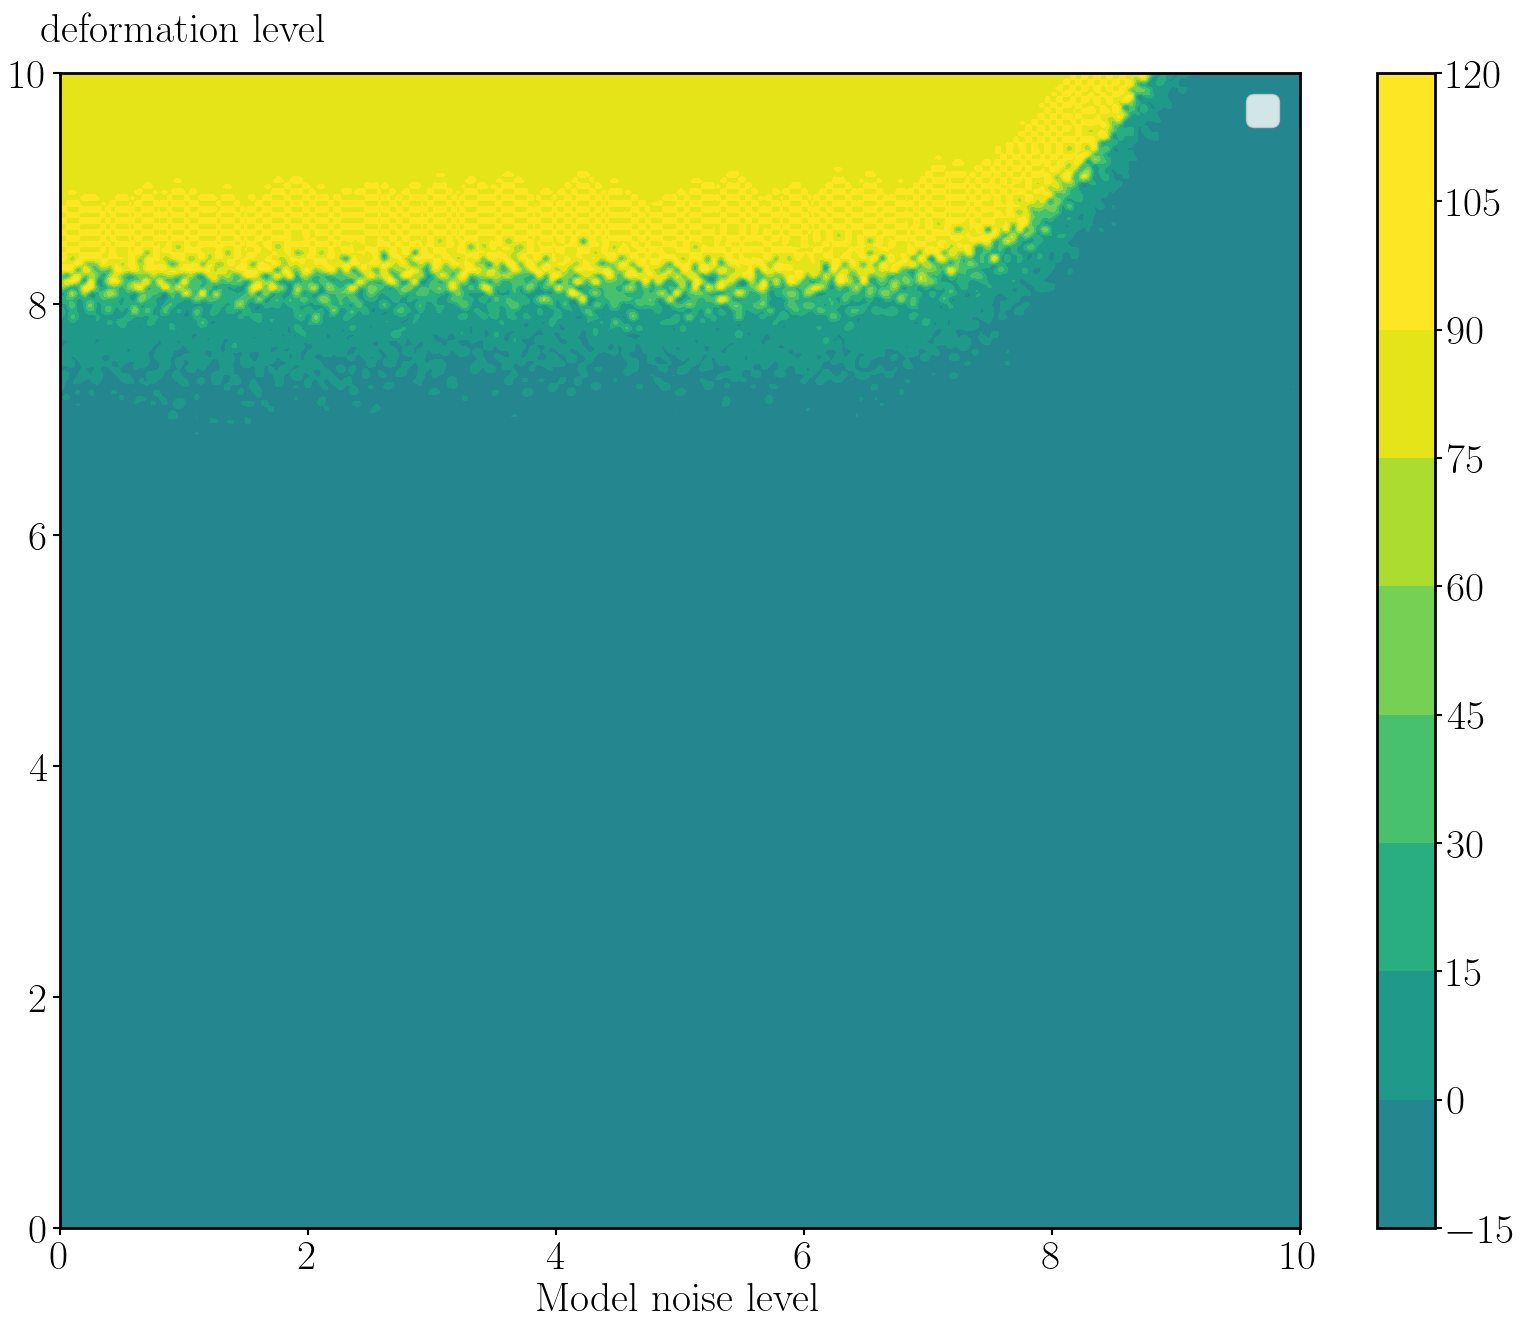

In [39]:
fig, ax = plt.subplots(figsize=(20, 15))
# Draw a contour plot to show the energy landscape of the model
energies = np.array([r["energy"] for r in results])
# remove outliers
scaled_energies = energies.copy()
scaled_energies[scaled_energies > 90] = 90
scaled_energies[scaled_energies < -90] = -90
smooth_scale = 3
z = ndimage.zoom(scaled_energies, smooth_scale)
x_range = deformation_scales.cpu().numpy()
plot_range = np.linspace(0, x_range.max(), len(x_range)*smooth_scale)
cntr = ax.contourf(
    plot_range,
    plot_range,
    z,
    levels=10,
    vmin=-90,
    vmax=90,
    )
plt.colorbar(cntr, ax=ax)
ax.set_xlabel("Model noise level")
ax.set_ylabel("Benzene\n deformation level", rotation="horizontal")
ax.yaxis.set_label_coords(0.1, 1.02)
# ax.plot([0, 15], [0, 15], color="violet", linewidth=3, label="Molecule generation trajectory")
# ax.plot(range(150), 150*np.ones(150), color="red", linewidth=3, label="MACE cutoff")
# ax.plot(150*np.ones(150), range(150), color="red", linewidth=3)
# ax.set_xlim(0, 150)
# ax.set_ylim(0, 150)
ax.legend()
# fig.savefig("benzene_diffusion_model_energy_landscape.png", bbox_inches="tight")
plt.show()